# More regression and `emcee`

Here I want to explore regression a little further, and in particular treat properly "non-informative priors", which is slightly tricky in `pymc3`.  I will also introduce `emcee` which is a more "bare metal" library, but has the advantage of being written in pure Python (using `numpy` directly) and (from my point of view, an advantage) being more overtly mathematical.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import pymc3 as pm
import theano.tensor as tt

# More regression

I don't want to ["standardise"](https://en.wikipedia.org/wiki/Standard_score) the variables, as it removes the original _units_ (and hence _meaning_) from the numbers.  This means we now need to consider the variable $a$, the intercept.

The concept of a [noninformative prior](https://en.wikipedia.org/wiki/Prior_probability#Uninformative_priors) in Bayesian statistics is a little complicated, but roughly we try to choose a prior which carries as little information as possible.  Following Gelman et al. (see references below) and in our notation, the common prior to take is
$$ p(a, b, \sigma^2) \propto \sigma^{-2}. $$
Notice I only give this prior as a "proportional to" and not "equal to": when using computation techniques, we don't need to specify constants.  In fact, in this case, we have an [inproper prior](https://en.wikipedia.org/wiki/Prior_probability#Improper_priors), as this the integral over $a,b,\sigma^2$ is not finite.  This is okay, because the posterior is always "proper".  Again, a formal justification for why we might want to do this is a little beyond these notebooks (see Gelman et al. or Wikipedia).

So, our task is: How do we implement this prior in `pymc3`?  Unfortunately, I don't see a really easy way to do this, so (warning: Calculus ahead) I proceed as follows.

- Let $s$ be a random variable which is "flat", so $p(s) = 1$ for all $s$
- Let $t = \exp(s)$.  By the [Change of variables](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables) rule, the density for $t$ satisfies
$$ p(t) = \Big| \frac{ds}{dt} \Big| \ p(s) = \frac{d}{dt} \log(t) = \frac{1}{t} $$
- So if we set $\sigma^2 = \exp(s)$ then this should have the required (inproper) prior density.

In [2]:
frame = pd.read_csv("with_stem.csv")

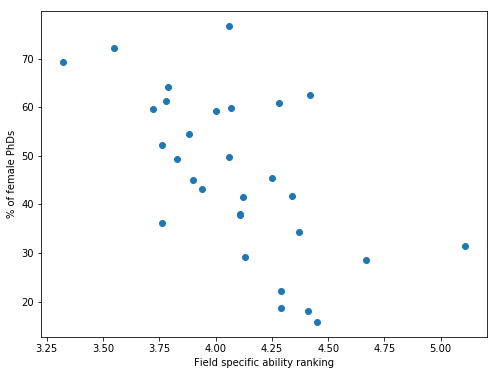

In [3]:
x = frame["FAB"]
y = frame["FEM"]

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x,y)
ax.set(xlabel="Field specific ability ranking", ylabel="% of female PhDs")
None

In [4]:
with pm.Model() as model:
    a = pm.Flat("a")
    b = pm.Flat("b")
    s = pm.Flat("s")
    sigma2 = pm.Deterministic("sigma2", tt.exp(s))
    
    predicted = a + tt.dot(x, b)
    obs = pm.Normal("y", mu=predicted, sd=tt.sqrt(sigma2), observed=y)
    
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████| 11000/11000 [01:05<00:00, 167.61it/s]


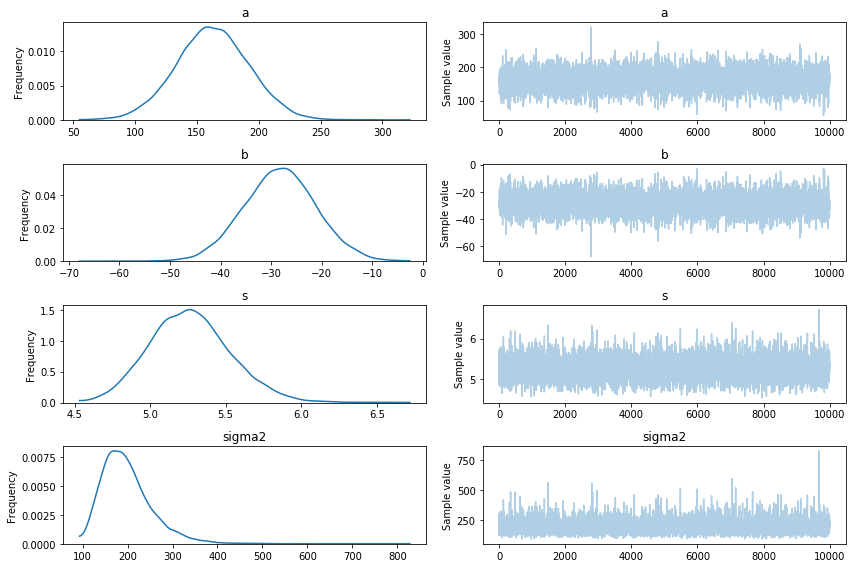

In [5]:
axes = pm.traceplot(trace)

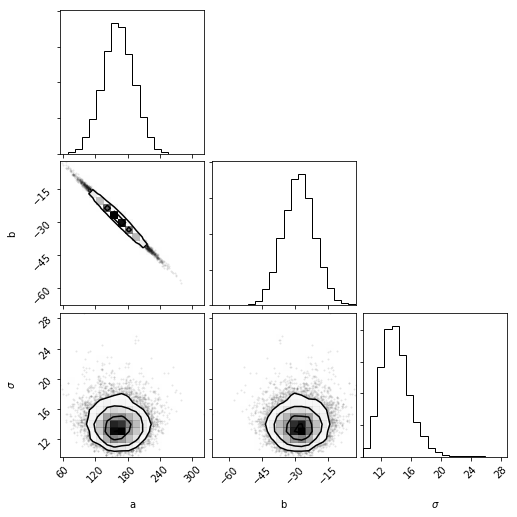

In [6]:
import corner
a = trace.get_values("a")
b = trace.get_values("b")
sigma = np.sqrt(trace.get_values("sigma2"))
fig = corner.corner(np.vstack([a,b,sigma]).T, labels=["a", "b", "$\sigma$"])

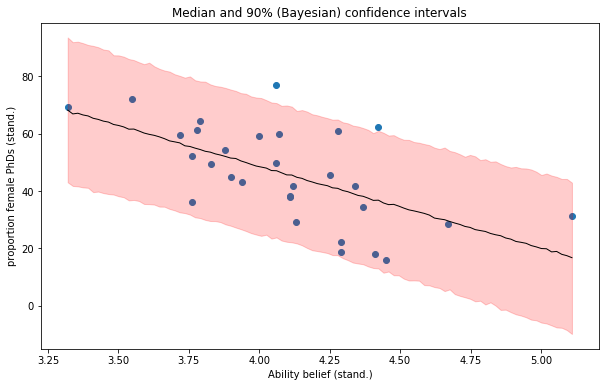

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x, y)
ax.set(xlabel="Ability belief (stand.)", ylabel="proportion female PhDs (stand.)")

xcs = np.linspace(min(x), max(x), 100)

a = trace.get_values("a")
b = trace.get_values("b")
sigma2 = np.abs(trace.get_values("sigma2"))

samples = np.random.normal(loc=b[:,None] * xcs[None,:] + a[:,None], scale=np.sqrt(sigma2[:,None]))
lower, median, upper = np.percentile(samples, [5,50,95], axis=0)
    
ax.plot(xcs, median, linewidth=1, color="black")
ax.fill_between(xcs, lower, upper, color="red", alpha=0.2)
ax.set_title("Median and 90% (Bayesian) confidence intervals")
None

Note that this looks extremely similar to the plot we have before-- this is a common occurance with simple models, and a reasonable amount of data, as the data dominates any (reasonable) prior.

# Using `emcee`

Install simply with `pip install emcee`.  [Documentation is available](http://dfm.io/emcee/current/).

To use this package, we have to get our hands dirty, and compute the log likelihood of our model:
- The prior is $p(a,b,\sigma^2) \propto \sigma^{-2}$ and so $\log p = -\log(\sigma^2)$ up to a constant
- The actual likelihood, $p(\text{data}\mid a,b,\sigma^2)$.  Our model is $y = a + bx + \epsilon$ with $\epsilon \sim N(0,\sigma^2)$, or equivalently, $y \sim N(a+bx,\sigma^2)$.  Thus the likelihood is
$$ \prod_i \frac{1}{\sqrt{2\pi\sigma^2}} \exp\Big( -\frac{(y_i-a-bx_i)^2}{2\sigma^2} \Big). $$

We don't want to allow $\sigma^2<0$ (as $\sigma^2$ is always non-negative!)  To enforce this, we check, and return a log likelihood of $-\infty$ if the parameter is out of range.

In [8]:
import emcee

In [9]:
def data_log_likelihood(p, data):
    """
    :param p: Tuple of (a,b,:math:`sigma^2`).
    :param data: `(x,y)`
    """
    a, b, sigma2 = p
    x, y = data
    n = len(y)
    ll = np.log(2 * np.pi * sigma2) * (-n/2)
    xb = y - (a + b * x)
    ll -= np.sum(xb**2) / (2 * sigma2)
    return ll

def log_likelihood(p, data):
    sigma2 = p[-1]
    if sigma2 <= 0:
        return -np.inf
    ll = -np.log(sigma2)
    return ll + data_log_likelihood(p, data)

In [10]:
# We'll run 10 parallel chains
nwalkers = 10
# Initial conditions: random
p0 = np.random.rand(3 * nwalkers).reshape((nwalkers, 3))

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, 3, log_likelihood, args=((x.values, y.values),))

In [12]:
# Run the markov chain for a while to get some proper initial conditions, and then reset
pos, prob, state = sampler.run_mcmc(p0, 1000)
sampler.reset()

In [13]:
# Now run the sampler for real
_ = sampler.run_mcmc(pos, 20000)

In [14]:
# Collect all the samples
samples = sampler.flatchain

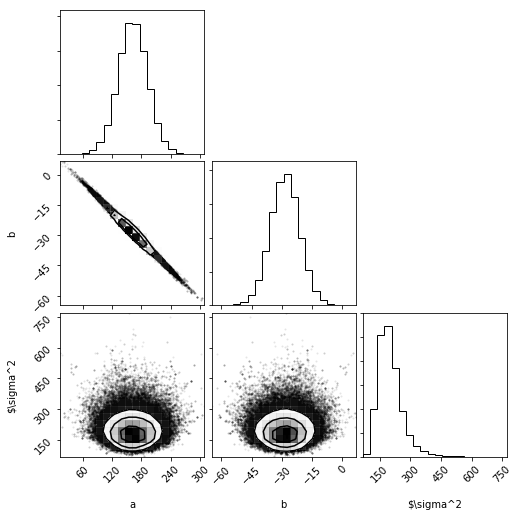

In [15]:
_ = corner.corner(samples, labels=["a", "b", "$\sigma^2"])

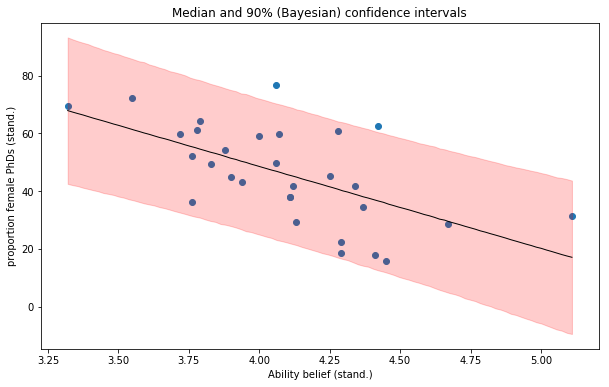

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x, y)
ax.set(xlabel="Ability belief (stand.)", ylabel="proportion female PhDs (stand.)")

xcs = np.linspace(min(x), max(x), 100)

a = samples[:,0]
b = samples[:,1]
sigma2 = samples[:,2]

samples = np.random.normal(loc=b[:,None] * xcs[None,:] + a[:,None], scale=np.sqrt(sigma2[:,None]))
lower, median, upper = np.percentile(samples, [5,50,95], axis=0)
    
ax.plot(xcs, median, linewidth=1, color="black")
ax.fill_between(xcs, lower, upper, color="red", alpha=0.2)
ax.set_title("Median and 90% (Bayesian) confidence intervals")
None